# Calculating sensitivity of time-domain EM with BDF2

In [3]:
import numpy as np
from discretize import TensorMesh, CylMesh
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
from simpegaem import SimulationAEM
from SimPEG import utils
import SimPEG.electromagnetics.time_domain as tdem
from SimPEG import maps
from pymatsolver import PardisoSolver
# from pymatsolver import Solver
%matplotlib inline

In [4]:
# cell size, number of cells in the x-direction, 
# number of cells in the z-direction and number of padding cells
mesh_type = '2d_cyl'

if mesh_type== '2d_cyl':
    ncx = 10
    csx = 10.
    npadx = 20.
    ncz = 10.
    csz = 5.
    npadz = 18.
    hx = [(csx, ncx), (csx, npadx, 1.3)]
    hz = [(csz, npadz, -1.3), (csz, ncx), (csz, npadz, 1.3)]    
    mesh = CylMesh([hx, 1, hz], x0='00C')
elif mesh_type == '3d_tensor':
    cs, ncx, npad = 10., 9, 8    
    ncy = 1
    ncz = 6
    hx = [(cs, npad, -1.3), (cs, ncx), (cs, npad, 1.3)]
    hy = [(cs, npad, -1.3), (cs, ncy), (cs, npad, 1.3)]    
    hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
    mesh = TensorMesh([hx, hy, hz], 'CCC')
active = mesh.cell_centers[:,2] < 0.
sigma_background = 1./20
sigma_layer = 1./20
sigma = np.ones(mesh.n_cells)*1e-8
sigma[active] = sigma_background
ind_layer = np.logical_and(mesh.cell_centers[:,2]<-100., mesh.cell_centers[:,2]>-200.)
sigma[ind_layer] = sigma_layer
rho = 1./sigma

eps = 1e-8
start_time = -0.02
peak_time = -0.01
off_time = 0.
triangle_waveform = tdem.sources.TriangularWaveform(
        start_time=start_time, peak_time=peak_time, off_time=off_time
)
triangle_waveform.has_initial_fields = True
receiver_orientation = "z"                    # "x", "y" or "z"
z_src = 30
x_rx = 10.
z_offset = 0.
receiver_location = np.array([x_rx, 0., z_src+z_offset])
source_location = np.array([0., 0., z_src])
times = np.logspace(np.log10(1e-5), np.log10(1e-2), 31)
rx = tdem.receivers.PointMagneticFluxTimeDerivative(
    receiver_location, times, orientation=receiver_orientation
)


receiver_list = [rx]
src = tdem.sources.MagDipole(
    receiver_list=receiver_list, location=source_location,
    waveform=triangle_waveform, orientation='z'
)


# Survey
source_list = [src]
survey = tdem.Survey(source_list)

    
def generate_time_steps(
    n_constant_steps=15, increase_rate=3, start_time_step=5e-7, n_per_step=5
):
    time_steps = []
    for i_step in range(n_constant_steps):
        ht = np.ones(n_per_step) * start_time_step*increase_rate**i_step
        time_steps.append(ht)
    print("t_min:{:.1e}, t_max:{:.1e}".format(start_time_step, np.sum(time_steps)))
    return np.hstack(time_steps)
# dts = np.diff(np.logspace(-7, -1, 60))
# time_steps = []
# for dt in dts:
#     time_steps.append((dt, 1))

time_steps = generate_time_steps(n_constant_steps=20, increase_rate=2, start_time_step=1e-7, n_per_step=5)

simulation_3d = SimulationAEM(
    mesh=mesh,
    survey=survey,
    sigmaMap=maps.IdentityMap(mesh),
    solver=PardisoSolver,
    time_steps=time_steps
)    

t_min:1.0e-07, t_max:5.2e-01


/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/utils/code_utils.py:148: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)


In [5]:
from scipy.special import roots_legendre
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

def get_convolution_matrix(times_step, rx, wave):
    t_min = np.infty
    t_max = -np.infty
    x, w = roots_legendre(251)
    times = rx.times - wave.time_nodes[:, None]
    times[times < 0.0] = 0.0
    quad_points = (times[:-1] - times[1:])[..., None] * (
        x + 1
    ) + times[1:, :, None]
    t_min = min(quad_points[quad_points > 0].min(), t_min)
    t_max = max(quad_points[quad_points > 0].max(), t_max)
    
    n_t = len(times_step)
    splines = []
    for i in range(n_t):
        e = np.zeros(n_t)
        e[i] = 1.0
        sp = iuSpline(np.log(times_step), e, k=5)
        splines.append(sp)
    # As will go from frequency to time domain

    def func(t, i):
        out = np.zeros_like(t)
        t = t.copy()
        t[
            (t > 0.0) & (t <= times_step.min())
        ] = times_step.min()  # constant at very low ts
        out[t > 0.0] = splines[i](np.log(t[t > 0.0])) 
        # / t[t > 0.0]
        return out

    # Then calculate the values at each time
    A = np.zeros((len(rx.times), n_t))
    # loop over pairs of nodes and use gaussian quadrature to integrate

    time_nodes = wave.time_nodes
    n_interval = len(time_nodes) - 1
    quad_times = []
    for i in range(n_interval):
        b = rx.times - time_nodes[i]
        b = np.maximum(b, 0.0)
        a = rx.times - time_nodes[i + 1]
        a = np.maximum(a, 0.0)
        quad_times = (b - a)[:, None] * (x + 1) / 2.0 + a[:, None]
        quad_scale = (b - a) / 2
        wave_eval = wave.eval_deriv(rx.times[:, None] - quad_times)
        for i in range(n_t):
            A[:, i] -= np.sum(
                quad_scale[:, None]
                * w
                * wave_eval
                * func(quad_times, i),
                axis=-1,
            )    
    return A

$$ V_{step} \otimes dI/dt = V_{data}$$

$$ P_{conv} V_{step} = V_{data}$$

(n_data, n_time_step); (n_data x 1)

In [6]:
def bdf2(sigma):
    simulation_3d.model = sigma
    # Operators
    C = mesh.edgeCurl
    MfMui = simulation_3d.MfMui
    MeSigma = simulation_3d.MeSigma
    n_steps = simulation_3d.time_steps.size
    Fz = mesh.getInterpolationMat(rx.locations, locType='Fz')
    eps = 1e-10
    def getA(dt, factor=1.):
        return C.T*MfMui*C + factor/dt * MeSigma
    dt_0 = 0.
    sol = np.zeros((mesh.n_edges, simulation_3d.time_steps.size), order='F', dtype=float)
    data_step = np.zeros(simulation_3d.time_steps.size)
    # sol_n0 = np.zeros(mesh.nE)
    # sol_n1 = np.zeros(mesh.nE)
    # sol_n2 = np.zeros(mesh.nE)
    for tInd in range(n_steps):
        dt = simulation_3d.time_steps[tInd]
        #Factor for BDF2
        factor=3/2.            
        if abs(dt_0-dt) > eps:
            # print (tInd, factor)
            A = getA(dt, factor=factor)            
            Ainv = simulation_3d.solver(A)
        if tInd==0:        
            b0 = src.bInitial(simulation_3d)
            s_e = C.T*MfMui*b0
            rhs = factor/dt*s_e
        elif tInd==1:
            rhs = -factor/dt*(MeSigma*(-4/3.*sol[:,tInd-1]+1/3.*sol[:,tInd-2]) + 1./3.*s_e)
        else:
            rhs = -factor/dt*(MeSigma*(-4/3.*sol[:,tInd-1]+1/3.*sol[:,tInd-2]))
        sol[:,tInd] = Ainv*rhs
        data_step[tInd] = Fz*(-C*sol[:,tInd])
        dt_0 = dt
    data_step = (Fz@(-C@sol)).flatten()
    times_step = simulation_3d.time_mesh.cell_centers
    P = get_convolution_matrix(times_step, rx, triangle_waveform)
    data_bdf2 = P @ data_step
    return sol, data_bdf2

In [7]:
from SimPEG.utils import plot_1d_layer_model

# Layer thicknesses
thicknesses = np.array([100.0, 100.0])
n_layer = len(thicknesses) + 1

# physical property model (conductivity model)
model = sigma_background * np.ones(n_layer)
model[1] = sigma_layer

# Define a mapping from model parameters to conductivities
model_mapping = maps.IdentityMap(nP=n_layer)

# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=thicknesses,
    sigmaMap=model_mapping,
)

# Predict data for a given model
sigma_1d =  model
data_analytic = simulation.dpred(sigma_1d)
data_analytic


array([-2.45420945e-11, -2.14943963e-11, -1.86199025e-11, -1.59502209e-11,
       -1.35094107e-11, -1.13129357e-11, -9.36734695e-12, -7.67069297e-12,
       -6.21355160e-12, -4.98050193e-12, -3.95182248e-12, -3.10520747e-12,
       -2.41733236e-12, -1.86515603e-12, -1.42690392e-12, -1.08272898e-12,
       -8.15081030e-13, -6.08838132e-13, -4.51260022e-13, -3.31821354e-13,
       -2.41975442e-13, -1.74886390e-13, -1.25159327e-13, -8.85850921e-14,
       -6.19120550e-14, -4.26477322e-14, -2.88932723e-14, -1.92073412e-14,
       -1.24990829e-14, -7.94389349e-15, -4.92112664e-15])

In [8]:
%%time
sol_bdf2, data_bdf2 = bdf2(sigma)

/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/utils/code_utils.py:216: FutureWarning: CylMesh.edgeCurl has been deprecated, please use CylMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, warn)
/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/utils/code_utils.py:264: FutureWarning: CylMesh.getInterpolationMat has been deprecated, please use CylMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
/Users/sgkang09/anaconda3/lib/python3.10/site-packages/discretize/cylindrical_mesh.py:1679: FutureWarning: The locType keyword argument has been deprecated, please use location_type. This will be removed in discretize 1.0.0
  warnings.warn(
/Users/sgkang09/anaconda3/lib/python3.10/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/Users/sgkang09/anaconda3/lib/

CPU times: user 2.92 s, sys: 1.31 s, total: 4.23 s
Wall time: 1.96 s


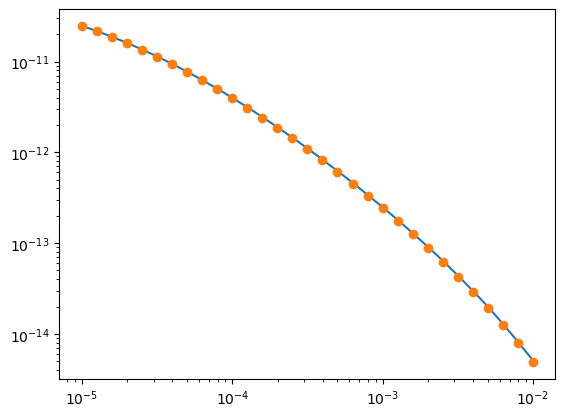

In [9]:
plt.loglog(rx.times, -data_bdf2)
plt.loglog(rx.times, -data_analytic, 'o')

In [10]:
from SimPEG import maps
active_map = maps.InjectActiveCells(mesh, indActive=active, valInactive=np.log(1e-8))
exp_map = maps.ExpMap(mesh)
mapping = exp_map * active_map

m = np.ones(active.sum()) * np.log(1./20.)
sigma = mapping * m

In [11]:
C = mesh.edge_curl
Fz = mesh.get_interpolation_matrix(rx.locations, locType='Fz')
PsT = -(Fz@C).T.toarray()

# Let's rewrite derivation for BDF2, and check.          ! BIT_061523
def getAdiag(self, tInd):
    """
    Diagonal of the system matrix at a given time index
    """
    assert tInd >= 0 and tInd < self.nT

    dt = self.time_steps[tInd]
    C = self.mesh.edge_curl
    MfMui = self.MfMui
    MeSigma = self.MeSigma
    return C.T.tocsr() * (MfMui * C) + (3./2.) / dt * MeSigma

def getAdiagDeriv(self, tInd, u, v, adjoint=False):
    """
    Deriv of ADiag with respect to electrical conductivity
    """
    assert tInd >= 0 and tInd < self.nT

    dt = self.time_steps[tInd]
    # MeSigmaDeriv = self.MeSigmaDeriv(u)

    if adjoint:
        return (3./2.) / dt * self.MeSigmaDeriv(u, v, adjoint)

    return (3./2.) / dt * self.MeSigmaDeriv(u, v, adjoint)

def getAsubdiag(self, tInd):
    """
    Matrix below the diagonal
    """
    assert tInd >= 0 and tInd < self.nT

    dt = self.time_steps[tInd]
    if tInd == 0:
        factor = -3./2.
    else:
        factor = -2.
    return factor / dt * self.MeSigma

def getAsubdiagDeriv(self, tInd, u, v, adjoint=False):
    """
    Derivative of the matrix below the diagonal with respect to electrical
    conductivity
    """
    dt = self.time_steps[tInd]
    if tInd == 0:
        factor = -3./2.
    else:
        factor = -2.
    if adjoint:
        return factor / dt * self.MeSigmaDeriv(u, v, adjoint)

    return factor / dt * self.MeSigmaDeriv(u, v, adjoint)

def getAsubsubdiag(self, tInd):
    """
    Matrix below the diagonal
    """
    assert tInd >= 0 and tInd < self.nT

    dt = self.time_steps[tInd]

    return 0.5 / dt * self.MeSigma

def getAsubsubdiagDeriv(self, tInd, u, v, adjoint=False):
    """
    Derivative of the matrix below the diagonal with respect to electrical
    conductivity
    """
    dt = self.time_steps[tInd]

    if adjoint:
        return 0.5 / dt * self.MeSigmaDeriv(u, v, adjoint)

    return 0.5 / dt * self.MeSigmaDeriv(u, v, adjoint)

def get_J_sigma_bdf2(sigma):
    simulation_3d.model = sigma
    C = mesh.edgeCurl
    n_steps = simulation_3d.time_steps.size
    eps = 1e-10
    nE = mesh.n_edges
    nD = rx.nD
    nT = len(simulation_3d.time_steps)
    nM = mesh.n_cells
    dt_0 = 0.
    nC = mesh.n_cells
    yn = np.zeros((nE, nD), dtype=float, order='F')
    yn_1 = np.zeros((nE, nD), dtype=float, order='F')
    yn_2 = np.zeros((nE, nD), dtype=float, order='F')
    J_matrixT = np.zeros((nM, nD), dtype=float, order='F')
    times_step = simulation_3d.time_mesh.cell_centers
    P = get_convolution_matrix(times_step, rx, triangle_waveform)
    sol, _ = bdf2(sigma)    
    for tInd in reversed(range(n_steps)):
        # print (tInd, tInd-1, tInd-2)
        dt = simulation_3d.time_steps[tInd]
        A = getAdiag(simulation_3d, tInd)
        pn = (PsT * P.T[tInd, :])
        if abs(dt_0-dt) > eps:
            # print (tInd)
            Ainv = simulation_3d.solver(A)
        if tInd==n_steps-1:
            yn = Ainv * pn
        elif tInd==n_steps-2: 
            BB = getAsubdiag(simulation_3d, tInd+1)
            yn = Ainv * (pn-BB@yn_1)   
        else:
            BB = getAsubdiag(simulation_3d, tInd+1)
            CC = getAsubsubdiag(simulation_3d, tInd+2)
            yn = Ainv * (pn-BB@yn_1 -CC@yn_2)   
        dAT_dm = getAdiagDeriv(simulation_3d, tInd, sol[:,tInd], v=None, adjoint=True) @ yn
        if tInd == 0:
            dAsubdiagT_dm = utils.Zero()
            dAsubsubdiagT_dm = utils.Zero()
        elif tInd == 1:
            dAsubdiagT_dm = getAsubdiagDeriv(simulation_3d, tInd, sol[:,tInd-1], v=None, adjoint=True) @ yn
            dAsubsubdiagT_dm = utils.Zero()
        else:
            dAsubdiagT_dm = getAsubdiagDeriv(simulation_3d, tInd, sol[:,tInd-1], v=None, adjoint=True) @ yn
            dAsubsubdiagT_dm = getAsubsubdiagDeriv(simulation_3d, tInd, sol[:,tInd-2], v=None, adjoint=True) @ yn
        J_matrixT = J_matrixT + -dAT_dm - dAsubdiagT_dm - dAsubsubdiagT_dm
        yn_2 = yn_1
        yn_1 = yn
        dt_0 = dt
    return J_matrixT.T

In [12]:
simulation_3d.model = sigma
C = mesh.edgeCurl
n_steps = simulation_3d.time_steps.size
eps = 1e-10
nE = mesh.n_edges
nD = rx.nD
nT = len(simulation_3d.time_steps)
nM = mesh.n_cells
dt_0 = 0.
nC = mesh.n_cells
yn = np.zeros((nE, nD), dtype=float, order='F')

In [13]:
%%time
# J_sigma = get_J_sigma_bdf1(sigma)
J_sigma = get_J_sigma_bdf2(sigma)

CPU times: user 4.75 s, sys: 1.74 s, total: 6.48 s
Wall time: 821 ms


In [14]:
def dpred(m):
    sigma = mapping * m    
    _, dpred = bdf2(sigma)
    return dpred

def dpred_dm(m, obs):
    sigma = mapping * m
    uncert = abs(obs) * 0.03
    return utils.sdiag(1./uncert) @ get_J_sigma_bdf2(sigma) * mapping.deriv(m)

def data_misfit(m, obs):
    pred = dpred(m)
    uncert = abs(obs) * 0.03
    r = (pred-obs) / uncert
    return np.linalg.norm(r)**2

def data_misfit_dm(m, obs):
    pred = dpred(m)
    uncert = abs(obs) * 0.03
    r = (pred-obs) / uncert
    J = dpred_dm(m, obs)
    return 2*J.T@r

In [15]:
# Order test for BDF1 
factors = [0.1, 0.01, 0.001, 0.0001]
m_true = np.ones(active.sum()) * np.log(1./20.)
m_0 = m_true * 2

obs = dpred(m_true)
dm0 = m_0*2

order_1 = np.zeros(len(factors))
order_2 = np.zeros(len(factors))

for ii, factor in enumerate(factors):
    dm = dm0 * factor
    order_1[ii] = np.linalg.norm(
        data_misfit(m_0+dm, obs)-data_misfit(m_0, obs)
    )**2
    order_2[ii] = np.linalg.norm(
        data_misfit(m_0+dm, obs)-data_misfit(m_0, obs)-data_misfit_dm(m_0, obs).dot(dm.T)
    )**2
#     print (">> {:.1e}, {:.1e}, {:.1e}".format(factor, order_1[ii], order_2[ii]))
    if ii > 0:
        ratio_1 = order_1[ii]/order_1[ii-1]
        ratio_2 = order_2[ii]/order_2[ii-1]
        
        print (">> {:.1e}, {:.1e}, {:.1e}, {:.1f}".format(factor, order_1[ii], order_2[ii], np.log10(ratio_1/ratio_2)))
    else:
        print (">> {:.1e}, {:.1e}, {:.1e}, {:.1f}".format(factor, order_1[ii], order_2[ii], np.nan))

>> 1.0e-01, 2.0e+06, 1.8e+06, nan
>> 1.0e-02, 6.5e+04, 3.6e+02, 2.2
>> 1.0e-03, 7.4e+02, 4.0e-02, 2.0
>> 1.0e-04, 7.5e+00, 4.0e-06, 2.0
